In [1]:
import numpy as np
import warnings
import re
warnings.filterwarnings('ignore')
from sklearn import metrics, cross_validation, preprocessing, pipeline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, Perceptron
from sklearn.ensemble import VotingClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics
# from catboost import CatBoostClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer ,normalize, scale,StandardScaler
import pickle
sns.set()
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import transliterate
 

warnings.filterwarnings('ignore')
%matplotlib inline

/home/maxim/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/maxim/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df=pd.read_csv('train.csv', encoding="utf-8")
df_test=pd.read_csv('test.csv', encoding="utf-8")

combine = [df, df_test]

In [3]:
CONS = u"бвгджзклмнпрстфхцчшщ"
VOV = u"аеёиоуыэюя"


for dataset in combine:
    #dataset.Word.apply(str)
    duplicates = np.array(dataset[dataset.duplicated('Word')].Word)
    duplicates_index=dataset[dataset.duplicated('Word') ].index.tolist() 
    
    dataset['index_ind'] =  dataset.index.tolist() 
    dataset['istitle'] =  dataset.Word.apply(lambda x: 1  if x.istitle()  else 0  )
    dataset['isupper'] =  dataset.Word.apply(lambda x: 1  if x.isupper()  else 0  )
    dataset['isalpha'] =  dataset.Word.apply(lambda x: 1  if x.isalpha()  else 0  )
    dataset['len']= dataset.Word.apply(lambda x: len(x) )
    #dataset['len_other']= dataset.Word.apply(lambda x: 1 if len(x)>=2 and len(x)<=11  else 0  )
    dataset['len_other']= dataset.Word.apply(lambda x: 1  )
    dataset['CONS_count'] = dataset.Word.apply(lambda x: 0 )
    #dataset['CONS_count'] = dataset.Word.apply(lambda x: len([char for char in x.lower() if char in CONS ]))
    dataset['VOV_count'] = dataset.Word.apply(lambda x: len([char for char in x.lower() if char in VOV ]))
    dataset['last_3'] =  dataset.Word.apply(lambda x:  x[-3:])
   # dataset['natasha_person'] =  dataset.Word.apply(function_natasha)
    
    dataset['duplicates'] = dataset.Word.apply(lambda x: 1 if x in duplicates else 0 )
    dataset['duplicates_ind'] =  dataset.index_ind.apply(lambda x:  1 if x in duplicates_index else 0)
    

    
train_col=['Word','last_3',  'VOV_count','CONS_count','len','isalpha','isupper','istitle','len_other']  


  
# ['duplicates_ind','duplicates','VOV_count','CONS_count','len_other','len','isalpha','isupper','istitle']

In [4]:
cat_col1=['Word']
global categorical_data_indices1
categorical_data_indices1 = np.array([(column in cat_col1) for column in df[train_col].columns], dtype = bool)
print (categorical_data_indices1)

cat_col2=['last_3']
global categorical_data_indices2
categorical_data_indices2 = np.array([(column in cat_col2) for column in df[train_col].columns], dtype = bool)
print (categorical_data_indices2)

float_col=['len','CONS_count','VOV_count']
global numeric_data_indices
numeric_data_indices = np.array([(column in float_col) for column in df[train_col].columns], dtype = bool)
print (numeric_data_indices)

global binary_data_indices 
binary_data_indices = np.array([(column not in float_col and column not in cat_col1 and column not in cat_col2) for column in df[train_col].columns], dtype = bool)
print (binary_data_indices)

[ True False False False False False False False False]
[False  True False False False False False False False]
[False False  True  True  True False False False False]
[False False False False False  True  True  True  True]


In [5]:
class ColumnExtractor_1st(object):
    
  #  def __init__(self, key):
   #     self.key = key

    def transform(self, X):
        cols = X[:,0] # column 1st column
        return cols

    def fit(self, X, y=None):
        return self
    
class ColumnExtractor_2st(object):
    


    def transform(self, X):
        cols = X[:,1] # column 2nd column
        return cols

    def fit(self, X, y=None):
        return self
    
class ColumnExtractor_3st(object):


    def transform(self, X):
        cols = X[:,2:5] # column  continous 
        return cols.astype(float)

    def fit(self, X, y=None):
        return self
    
class ColumnExtractor_4st(object):


    def transform(self, X):
        cols = X[:,5:] # column  continous 
        return cols.astype(float)

    def fit(self, X, y=None):
        return self

In [6]:
def MyPipe_v4(model):
    pipe = pipeline.Pipeline([
                         ('features', FeatureUnion([
                             ('word_CountVectorizer', pipeline.Pipeline([
                                 #('selecting', FunctionTransformer(lambda data: data[:, categorical_data_indices1])) ,
                           
                                 ('reduce_dim', ColumnExtractor_1st()),
                                 ('vect', CountVectorizer(ngram_range=(2,7), analyzer='char',lowercase=False)),
                                # ('TfidfTransformer',TfidfTransformer()),
                                 #('scl', scaler),
                                
                                 
                                 
                                 
                                 ])),
                            ('last_3_CountVectorizer', pipeline.Pipeline([
                                ('reduce_dim', ColumnExtractor_2st()),
                                ('vect', CountVectorizer(ngram_range=(2,3), analyzer='char',lowercase=False)),
                            ##     ('TfidfTransformer',TfidfTransformer()),
                                #('scl', scaler),
            
                                ])),
                             
                            ('continuous', pipeline.Pipeline([
                                  ('reduce_dim', ColumnExtractor_3st()),
                                  ('scaling', MaxAbsScaler())
                             ])),
                             ('binury', pipeline.Pipeline([
                                  ('reduce_dim', ColumnExtractor_4st()),
                                
                             ])),
                            
                        
                           
                             
                             
                             
                             
                             
        
        
        
        
                         
                              ])),
                              
                              
                              ('clf', model)
                            ])
    return pipe

In [7]:

cv = StratifiedKFold(df[df.duplicates==0].Label, n_folds=5, shuffle=True)
train_col=['Word','last_3',  'VOV_count','CONS_count','len','isalpha','isupper','istitle','len_other']



log_reg = LogisticRegression(penalty='l2', n_jobs=4, random_state=42,
                             class_weight='balanced',
                             C = 0.1, max_iter=50, solver='sag')


my_pipe_log=MyPipe_v4(log_reg)


score_log=cross_val_score(my_pipe_log, np.array(df[df.duplicates==0][train_col]), df[df.duplicates==0].Label, cv=cv, scoring='roc_auc')
print("valuesROC-AUC (LR): {}/{}".format(score_log.mean(), score_log.std()))

valuesROC-AUC (LR): 0.931015713067/0.00150023424529


In [8]:

cv = StratifiedKFold(df[df.duplicates==0].Label, n_folds=5, shuffle=True)
train_col=['Word','last_3',  'VOV_count','CONS_count','len','isalpha','isupper','istitle','len_other']

svm_sgd=SGDClassifier(loss='modified_huber', penalty='l2', alpha=1e-3, n_iter=200, random_state=42, 
                      n_jobs=4, class_weight='balanced')

sgd_pipe=MyPipe_v4(svm_sgd)


score_svm_sgd=cross_val_score(sgd_pipe,np.array(df[df.duplicates==0][train_col]), df[df.duplicates==0].Label, cv=cv, n_jobs=4, scoring='roc_auc')
print("ROC-AUC (LR): {}/{}".format(score_svm_sgd.mean(), score_svm_sgd.std()))
print score_svm_sgd.mean() , score_svm_sgd.std()

ROC-AUC (LR): 0.932636098363/0.00220553953636
0.932636098363 0.00220553953636


In [117]:
for clf__n_iter in  range(100,500,100):
    for clf__alpha in [1e-4, 1e-5, 1e-3]:
        for clf__penalty in [ "l2"]:
            for clf_loss in ['log']:
                svm_sgd=SGDClassifier(loss=clf_loss, penalty=clf__penalty, alpha=clf__alpha, n_iter=clf__n_iter, random_state=42, 
                      n_jobs=4, class_weight='balanced')
                sgd_pipe=MyPipe_v4(svm_sgd)
                score_svm_sgd=cross_val_score(sgd_pipe,np.array(df[df.duplicates==0][train_col]), df[df.duplicates==0].Label, cv=cv, n_jobs=4, scoring='roc_auc')
                print("ROC-AUC (LR): {}/{}".format(score_svm_sgd.mean(), score_svm_sgd.std())) ,clf_loss,clf__penalty,clf__alpha,clf__n_iter
                
            
            

ROC-AUC (LR): 0.93173131076/0.00332688209995 log l2 0.0001 100
ROC-AUC (LR): 0.933008103489/0.00288496463752 log l2 1e-05 100
ROC-AUC (LR): 0.917277988436/0.00428209187709 log l2 0.001 100
ROC-AUC (LR): 0.931715460078/0.00331303769308 log l2 0.0001 200
ROC-AUC (LR): 0.933152480475/0.00293851682033 log l2 1e-05 200
ROC-AUC (LR): 0.917262022596/0.00428199273337 log l2 0.001 200
ROC-AUC (LR): 0.931712082298/0.00332313049129 log l2 0.0001 300
ROC-AUC (LR): 0.933222722717/0.00294992605696 log l2 1e-05 300
ROC-AUC (LR): 0.917255592707/0.00428218628049 log l2 0.001 300
ROC-AUC (LR): 0.931709342456/0.00331837682179 log l2 0.0001 400
ROC-AUC (LR): 0.933225250152/0.00295598915346 log l2 1e-05 400
ROC-AUC (LR): 0.917253548041/0.00428334223714 log l2 0.001 400


In [56]:


cv = StratifiedKFold(df[df.duplicates==0].Label, n_folds=5, shuffle=True)
train_col=['Word','last_3',  'VOV_count','CONS_count','len','isalpha','isupper','istitle','len_other']

svm_sgd=SGDClassifier(loss='log', penalty='l2', alpha=1e-5, n_iter=300, random_state=42, 
                      n_jobs=4, class_weight='balanced')

sgd_pipe=MyPipe_v4(svm_sgd)

sgd_pipe.fit(np.array(df[df.duplicates==0][train_col]), df[df.duplicates==0].Label)
sgd_pred=sgd_pipe.predict_proba(np.array(df_test[train_col]))[:,1]
df_test['pred1']=sgd_pred

df_test.pred1[(df_test.duplicates==1) & (df_test.duplicates_ind==1) ]=1
df_test.pred1[(df_test.duplicates==1) & (df_test.duplicates_ind==0) ]=0

#score_svm_sgd=cross_val_score(sgd_pipe,np.array(df[df.duplicates==0][train_col]), df[df.duplicates==0].Label, cv=cv, n_jobs=4, scoring='roc_auc')
#print("ROC-AUC (LR): {}/{}".format(score_svm_sgd.mean(), score_svm_sgd.std()))
 

In [27]:
df_test['db']= df_test.Word.apply(lambda x: 1  if x in  df.Word.values  else 0  )

In [58]:
df_test_1=df_test.merge(df[['Word','Label']],on='Word', how='left')

In [63]:

df_test_1.pred1[df_test_1.Label==0]=1
df_test_1.pred1[df_test_1.Label==1]=0

In [65]:
preds=pd.DataFrame({'Id':range(len(df_test)),'Prediction': df_test_1.pred1})


In [66]:
preds.to_csv('hw0_v2.csv', sep=',',  index=False)

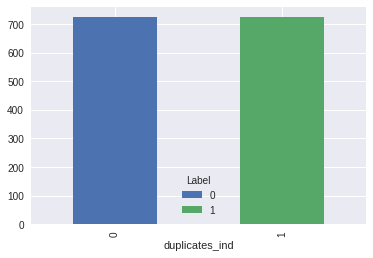

In [17]:
df[df.duplicates==1].pivot_table('Word','duplicates_ind','Label','count').plot(kind='bar', stacked=True)